<font size="5"> **Stable Diffusion Inference on Intel® Data Center GPU Max 1100** </font> 
<br>
This code sample will perform stable diffusion inference based on the text prompt using KerasCV implementation while using Intel® Extension for Tensorflow*. The following run cases are executed:<br>
* FP32 (baseline) <br>
* Advanced Auto Mixed Precision FP16 <br>

<font size="5">**Environment Setup**</font>  <br>
Ensure the **itex_xpu kernel** is activated before running this notebook.

In [2]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'
os.environ['ITEX_CPP_MIN_LOG_LEVEL'] = '2'
#os.environ['ZE_AFFINITY_MASK'] = str(gpu_device)

import time
from keras_cv.models import StableDiffusion
from tensorflow import keras
import matplotlib.pyplot as plt
import tensorflow as tf
import numpy as np

<font size ="5">**Helper Functions**</font>

The functions below will help us plot the images.

In [3]:
def plot_images(images):
    png_name = "{}_{}imgs_{}steps.png".format(
        precision, batch_size, num_steps)
    
    print("Start plotting the generated images to %s" % (png_name))
    plt.figure(figsize=(20, 20))
    for i in range(len(images)):
        ax = plt.subplot(1, len(images), i + 1)
        plt.imshow(images[i])
        plt.axis("off")

<font size ="5">**Model Loading**</font> <br>
First, we construct a model and also define few of the required parameters:</font>

In [4]:
iterations = 1  # number of iterations in performance measurements
use_xla = False  # TF XLA compiler
precision = 'fp32'
batch_size = 1
num_steps = 50  # num of UNET steps in Stable Diffusion
seed= 12345  # changing seed will produce different outputs
benchmark_result = []

model = StableDiffusion(
    img_width=512,
    img_height=512,
    jit_compile=use_xla,   
)

By using this model checkpoint, you acknowledge that its usage is subject to the terms of the CreativeML Open RAIL-M license at https://raw.githubusercontent.com/CompVis/stable-diffusion/main/LICENSE


<font size ="5">**Running Inference** </font> <br>
Next, we give it a prompt:

Start Warmup
1356917/1356917 [==============================] - 0s 0us/step


2023-10-08 03:58:41.853931: E itex/core/wrapper/itex_gpu_wrapper.cc:49] Could not load Intel Extension for Tensorflow* GPU backend, GPU will not be used.
If you need help, create an issue at https://github.com/intel/intel-extension-for-tensorflow/issues
2023-10-08 03:58:41.859066: E itex/core/wrapper/itex_gpu_wrapper.cc:49] Could not load Intel Extension for Tensorflow* GPU backend, GPU will not be used.
If you need help, create an issue at https://github.com/intel/intel-extension-for-tensorflow/issues


198180272/198180272 [==============================] - 1s 0us/step
Start running inference and generating images
50/50 [==============================] - 566s 11s/step
FP32 precision: 588.70 seconds
Start plotting the generated images to fp32_1imgs_50steps.png


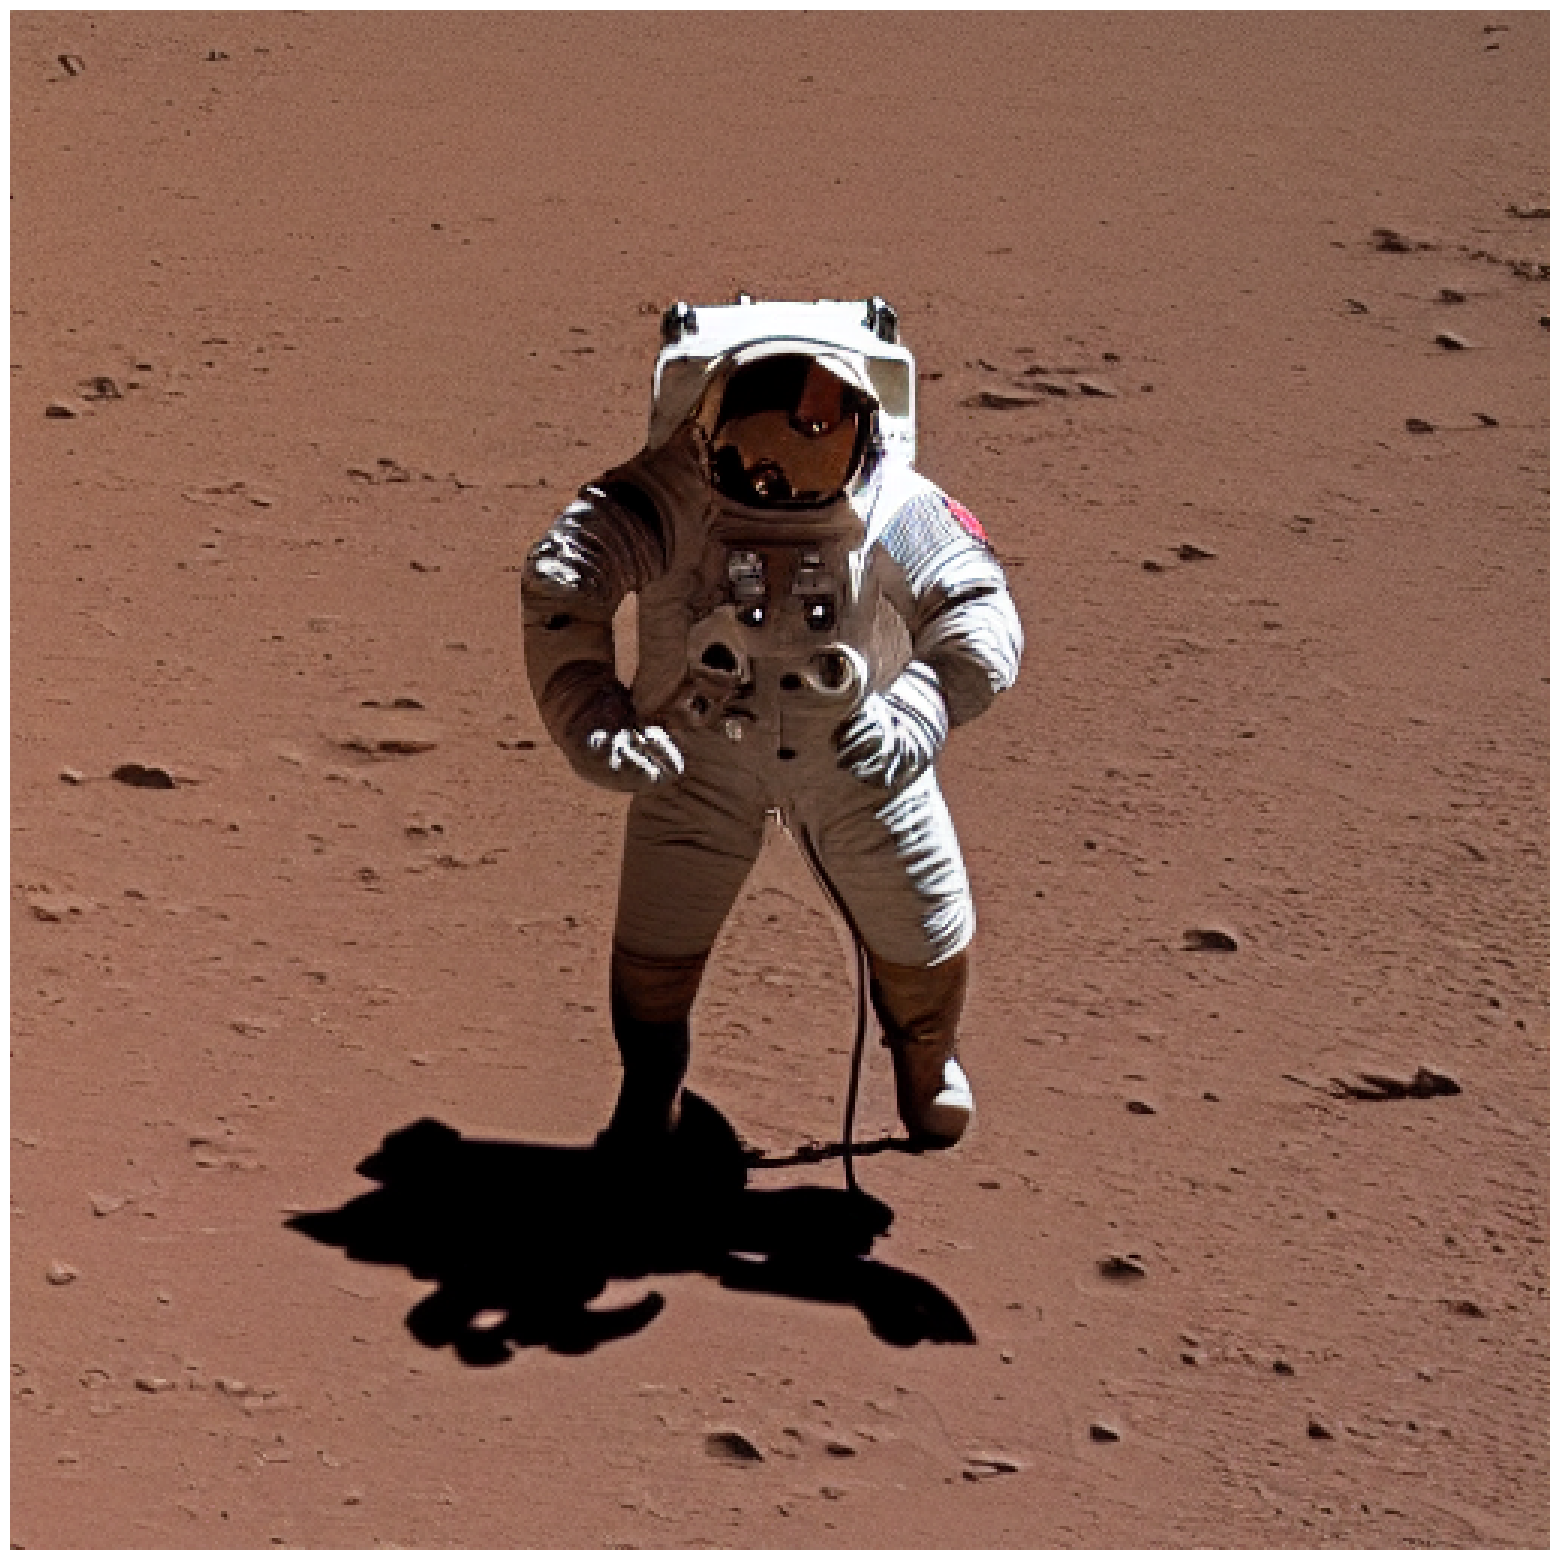

In [5]:
prompt = "an astronaut riding a horse on mars"
#prompt = "people attending intel conference in a big hall with an led screen" # This is the input for teext2image conversion


print("Start Warmup")
model.text_to_image(
    "warming up the model", batch_size=batch_size, num_steps=num_steps
) # Warming up the GPU caches before perf measurements
# Start inference
print("Start running inference and generating images")
t = 0
for i in range(iterations):
    start_time = time.time()
    images = model.text_to_image(prompt=prompt, batch_size=batch_size, seed=seed, num_steps=num_steps)
    t+=(time.time() - start_time)
print(f"FP32 precision: {(t/iterations):.2f} seconds")
benchmark_result.append(["FP32 precision", t/iterations])
plot_images(images)

<font size="4">**Performance computation using AMP BF16 precision** </font>
<br>
Enable Advanced AMP

In [6]:
import intel_extension_for_tensorflow as itex
print("intel_extension_for_tensorflow {}".format(itex.__version__))

auto_mixed_precision_options = itex.AutoMixedPrecisionOptions()
auto_mixed_precision_options.data_type = itex.FLOAT16 #Data precision for Advanced Auto mixed Precision

graph_options = itex.GraphOptions(auto_mixed_precision_options=auto_mixed_precision_options)
graph_options.auto_mixed_precision = itex.ON

config = itex.ConfigProto(graph_options=graph_options)
itex.set_config(config)

intel_extension_for_tensorflow 2.13.0.0


In [7]:
itex.get_config()

graph_options {
  auto_mixed_precision: ON
  auto_mixed_precision_options {
    data_type: FLOAT16
  }
}

In [ ]:
model = StableDiffusion(
    img_width=512,
    img_height=512,
    jit_compile=use_xla
)

print("Start Warmup")
model.text_to_image(
    "warming up the model", batch_size=batch_size, num_steps=num_steps
)
# Start inference
print("Start running inference and generating images")
t = 0
for i in range(iterations):
    start_time = time.time()
    images = model.text_to_image(prompt=prompt, batch_size=batch_size, seed=seed, num_steps=num_steps)
    t+=(time.time() - start_time)
    
print(f"AMP FP16 precision: {(t/iterations):.2f} seconds")
benchmark_result.append(["AMP FP16 precision", t/iterations])
plot_images(images)

By using this model checkpoint, you acknowledge that its usage is subject to the terms of the CreativeML Open RAIL-M license at https://raw.githubusercontent.com/CompVis/stable-diffusion/main/LICENSE
Start Warmup


2023-10-08 04:43:06.428519: I itex/core/graph/auto_mixed_precision/auto_mixed_precision.cc:118] Run advanced auto mixed precision datatype FLOAT16 on CPU
2023-10-08 04:43:06.804073: I itex/core/graph/auto_mixed_precision/auto_mixed_precision.cc:1742] Converted 408/1048 nodes to float16 precision using 25 cast(s) to float16 (excluding Const and Variable casts)
2023-10-08 04:43:06.939071: I itex/core/graph/auto_mixed_precision/auto_mixed_precision.cc:118] Run advanced auto mixed precision datatype FLOAT16 on CPU
2023-10-08 04:43:07.013998: I itex/core/graph/auto_mixed_precision/auto_mixed_precision.cc:1742] Converted 0/1215 nodes to float16 precision using 0 cast(s) to float16 (excluding Const and Variable casts)
2023-10-08 04:43:26.054910: I itex/core/graph/auto_mixed_precision/auto_mixed_precision.cc:118] Run advanced auto mixed precision datatype FLOAT16 on CPU
2023-10-08 04:43:27.354996: I itex/core/graph/auto_mixed_precision/auto_mixed_precision.cc:1742] Converted 1308/4072 nodes to

 1/50 [..............................] - ETA: 1:07:21

<font size ="5">**Performance comparison** <br></font>
Lets compare the results wrt inference latency time.

In [ ]:
print("{:<20} {:<20}".format("Model", "Runtime"))
for result in benchmark_result:
    name, runtime = result
    print("{:<20} {:<20}".format(name, runtime))

In [ ]:
import matplotlib.pyplot as plt

# Create bar chart with training time results
plt.figure(figsize=(4,3))
plt.title("Stable diffusion Inference on Intel Max GPU")
plt.ylabel("Inference Time (seconds)")
plt.bar(["FP32", "FP16-AMP"], [benchmark_result[0][1], benchmark_result[1][1]])

<font size ="5">**Explore Further** <br></font>
1. Improve the performance of KerasCV-Stable Diffusion still further by applying advanced optimizations. Refer [ITEX samples](https://github.com/intel/intel-extension-for-tensorflow/tree/main/examples/stable_diffussion_inference)
2. Try other interesting stable diffusion prompts and post the image on your social handle. <br> At #Intel #oneapi Devsummit. Ran @StableDiffusion text2image #AI on 4th Gen #intelxeon and Intel Datacenter Max 1100 #GPU  #intelai 
3. Experiment with other Tensorflow models from Tensorflow-hub on Intel GPU's 

<details>
<summary><b> Legal Notices and Disclaimers</b></summary>
Intel technologies’ features and benefits depend on system configuration and may require enabled hardware, software or service activation. Performance varies depending on system configuration. No computer system can be absolutely secure. Check with your system manufacturer or retailer or learn more at www.intel.com.<br>
Cost reduction scenarios described including recommendations are intended as examples of how a given Intel-based product, in the specified circumstances and configurations, may affect future costs and provide cost savings. Circumstances will vary. Intel does not guarantee any costs or cost reduction.<br>
This document contains information on products, services and/or processes in development. All information provided here is subject to change without notice. Contact your Intel representative to obtain the latest forecast, schedule, specifications and roadmaps. <br>
Any forecasts of goods and services needed for Intel’s operations are provided for discussion purposes only. Intel will have no liability to make any purchase in connection with forecasts published in this document.<br>
Intel technologies may require enabled hardware, software or service activation.<br>
Software and workloads used in performance tests may have been optimized for performance only on Intel microprocessors.  <br>
Performance tests, are measured using specific computer systems, components, software, operations and functions.  Any change to any of those factors may cause the results to vary.  You should consult other information and performance tests to assist you in fully evaluating your contemplated purchases, including the performance of that product when combined with other products.   For more complete information visit www.intel.com/benchmarks.<br>

|* Other names and brands may be claimed as the property of others. <br>

Your costs and results may vary. <br>
© Intel Corporation.  Intel, the Intel logo, and other Intel marks are trademarks of Intel Corporation or its subsidiaries.  Other names and brands may be claimed as the property of others.<br>
Copyright 2023 Intel Corporation.